In [1]:
# Load useful library
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.signal import convolve2d

# copy here useful functions previously seen

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

In [44]:
def quantification(v, K):
    return np.where(v==1, K, np.floor(v*K)+1)

In [51]:
def quantificationImage(I, nH, nS, nV):
    Iq = np.zeros(I.shape)
    histo = np.zeros((nH, nS, nV))
    
    Iq[:,:,0] = quantification(I[:,:,0], nH)
    Iq[:,:,1] = quantification(I[:,:,1], nS)
    Iq[:,:,2] = quantification(I[:,:,2], nV)
    
    Iq[:,:,0] *= (255 / nH)
    Iq[:,:,1] *= (255 / nS)
    Iq[:,:,2] *= (255 / nV)
    
    return np.uint8(Iq)

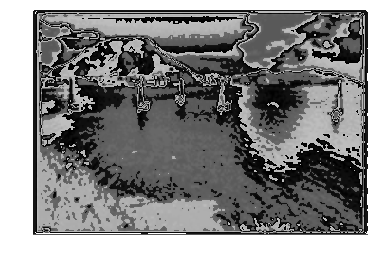

In [52]:
p67 = np.array(Image.open('Paysages67.png'))
imshow(quantificationImage(p67,12,3,8)[:,:,0])